# Customer Churn Prediction Project

In [1]:
import warnings

# Suppress all DeprecationWarnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## **1. Introduction:**

The goal of this project is to develop a classification model that predicts whether a customer will churn. By analyzing demographic data and service usage information, we aim to identify customers at high risk of churning. This will enable the company to design proactive retention strategies, improving customer satisfaction and reducing financial loss.

## **2. Data Exploration and Preprocessing**

### **2.1 Import Libraries:**

Before starting, we need to import the necessary Python libraries for data analysis, visualization, and machine learning.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


### **2.2 Load the Dataset:**

Load the dataset into a Pandas DataFrame for analysis.

In [3]:
# Load the dataset
data = pd.read_csv('customer_data.csv')  # Replace with your dataset file path
data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### **2.3 Analyze the Dataset:**

Explore the dataset to understand its structure, check for missing values, and identify trends or outliers.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


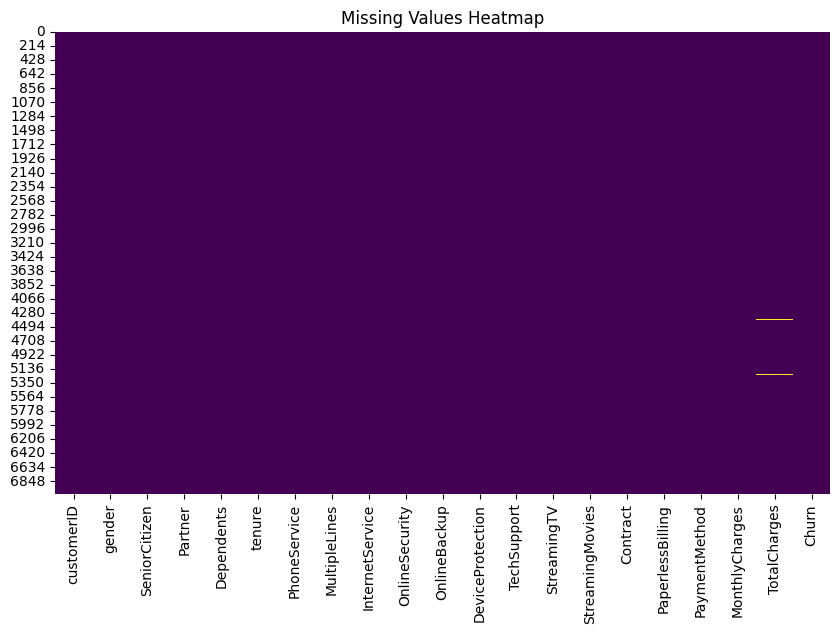

In [4]:
# Check dataset information
data.info()

# Check for missing values
data.isnull().sum()

# Summary statistics
data.describe()

# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


### **2.4 Handle Missing Values:**

Decide how to handle missing values (e.g., imputation or removal).

In [5]:
# Fill missing values for numerical columns with the median
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

# Fill missing values for categorical columns with the mode
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])


### **2.5 Feature Engineering**

Create new features that might be useful for the model, such as:

- **Tenure Groups**: Group customers based on their tenure (e.g., 0-12 months, 12-24 months, etc.).
- **Total Charges per Tenure**: Calculate the average monthly charges.

In [9]:
# Create tenure groups
data['tenure_group'] = pd.cut(data['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], labels=['0-12', '12-24', '24-36', '36-48', '48-60', '60-72'])

# Calculate average monthly charges
data['avg_monthly_charges'] = data['TotalCharges'] / data['tenure']
data['avg_monthly_charges'] = data['avg_monthly_charges'].fillna(0)  # Handle division by zero for new customers


### **2.6 Data Visualization:**

Visualize trends and relationships in the data.

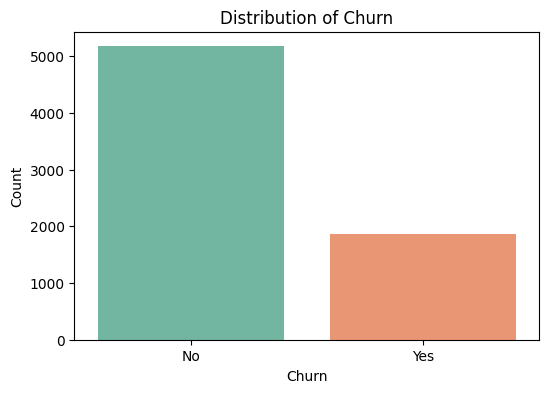

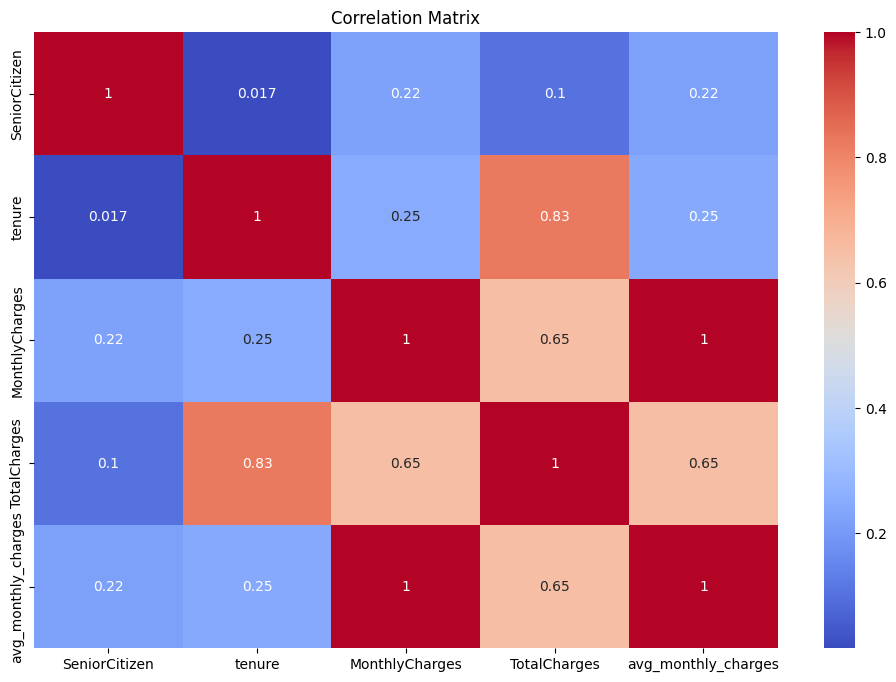

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of churn
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=data, hue='Churn', palette='Set2', legend=False)
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=['number'])

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## **3. Model Development**

### **3.1 Split the Data:**

Divide the dataset into training and testing sets.

In [13]:
# Define features (X) and target (y)
X = data.drop(['Churn', 'customerID'], axis=1)  # Drop non-relevant columns
y = data['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### **3.2 Preprocessing Pipeline:**

Create a preprocessing pipeline to handle numerical and categorical features.

In [14]:
# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### **3.3 Build and Train Models:**

Build and train different classification models, such as Logistic Regression, Decision Tree, Random Forest, etc.

In [17]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Check for infinite values in numeric columns of X_train and X_test
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

print("Infinite values in X_train (numeric columns):", np.isinf(X_train[numeric_cols]).sum().sum())
print("Infinite values in X_test (numeric columns):", np.isinf(X_test[numeric_cols]).sum().sum())

# Replace infinite values with NaN in numeric columns
X_train[numeric_cols] = X_train[numeric_cols].replace([np.inf, -np.inf], np.nan)
X_test[numeric_cols] = X_test[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Define preprocessing steps
numeric_features = numeric_cols
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Replace NaNs with mean
    ('scaler', StandardScaler())  # Scale numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace NaNs with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate models
for name, model in models.items():
    # Create a pipeline with preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Infinite values in X_train (numeric columns): 10
Infinite values in X_test (numeric columns): 1
Logistic Regression Accuracy: 0.8126
Decision Tree Accuracy: 0.7211
Random Forest Accuracy: 0.7921
SVM Accuracy: 0.8055
KNN Accuracy: 0.7693


### **3.4 Hyperparameter Tuning:**

Use GridSearchCV to find the best hyperparameters for each model.

In [18]:
# Example: Tuning Random Forest
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', RandomForestClassifier(random_state=42))])

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_search.best_params_)
print("Best Accuracy for Random Forest:", grid_search.best_score_)


Best Parameters for Random Forest: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best Accuracy for Random Forest: 0.8026261581936041


## **4. Model Evaluation**

### **4.1 Evaluate Model Performance:**

Evaluate the model using metrics like accuracy, precision, recall, and F1 score.

Accuracy: 0.8062
Precision: 0.6761
Recall: 0.5147
F1 Score: 0.5845


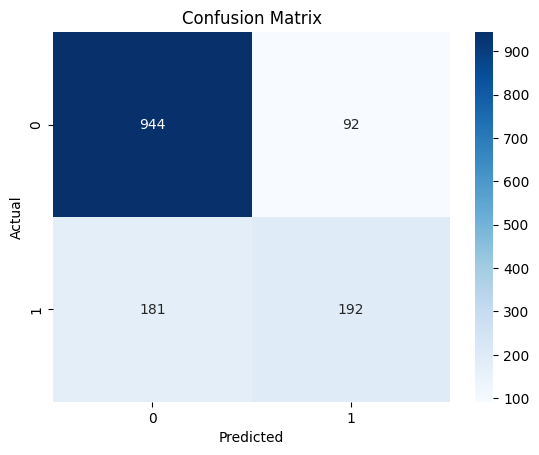

In [19]:
# Predict on the test set
y_pred = grid_search.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### **4.2 Classification Report**

Generate a detailed classification report.

In [20]:
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))


              precision    recall  f1-score   support

          No       0.84      0.91      0.87      1036
         Yes       0.68      0.51      0.58       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



## **5. Conclusion**

Summarize the findings, including the best-performing model and its key drivers of churn. Provide actionable insights for the company to reduce customer churn.